# Docling 

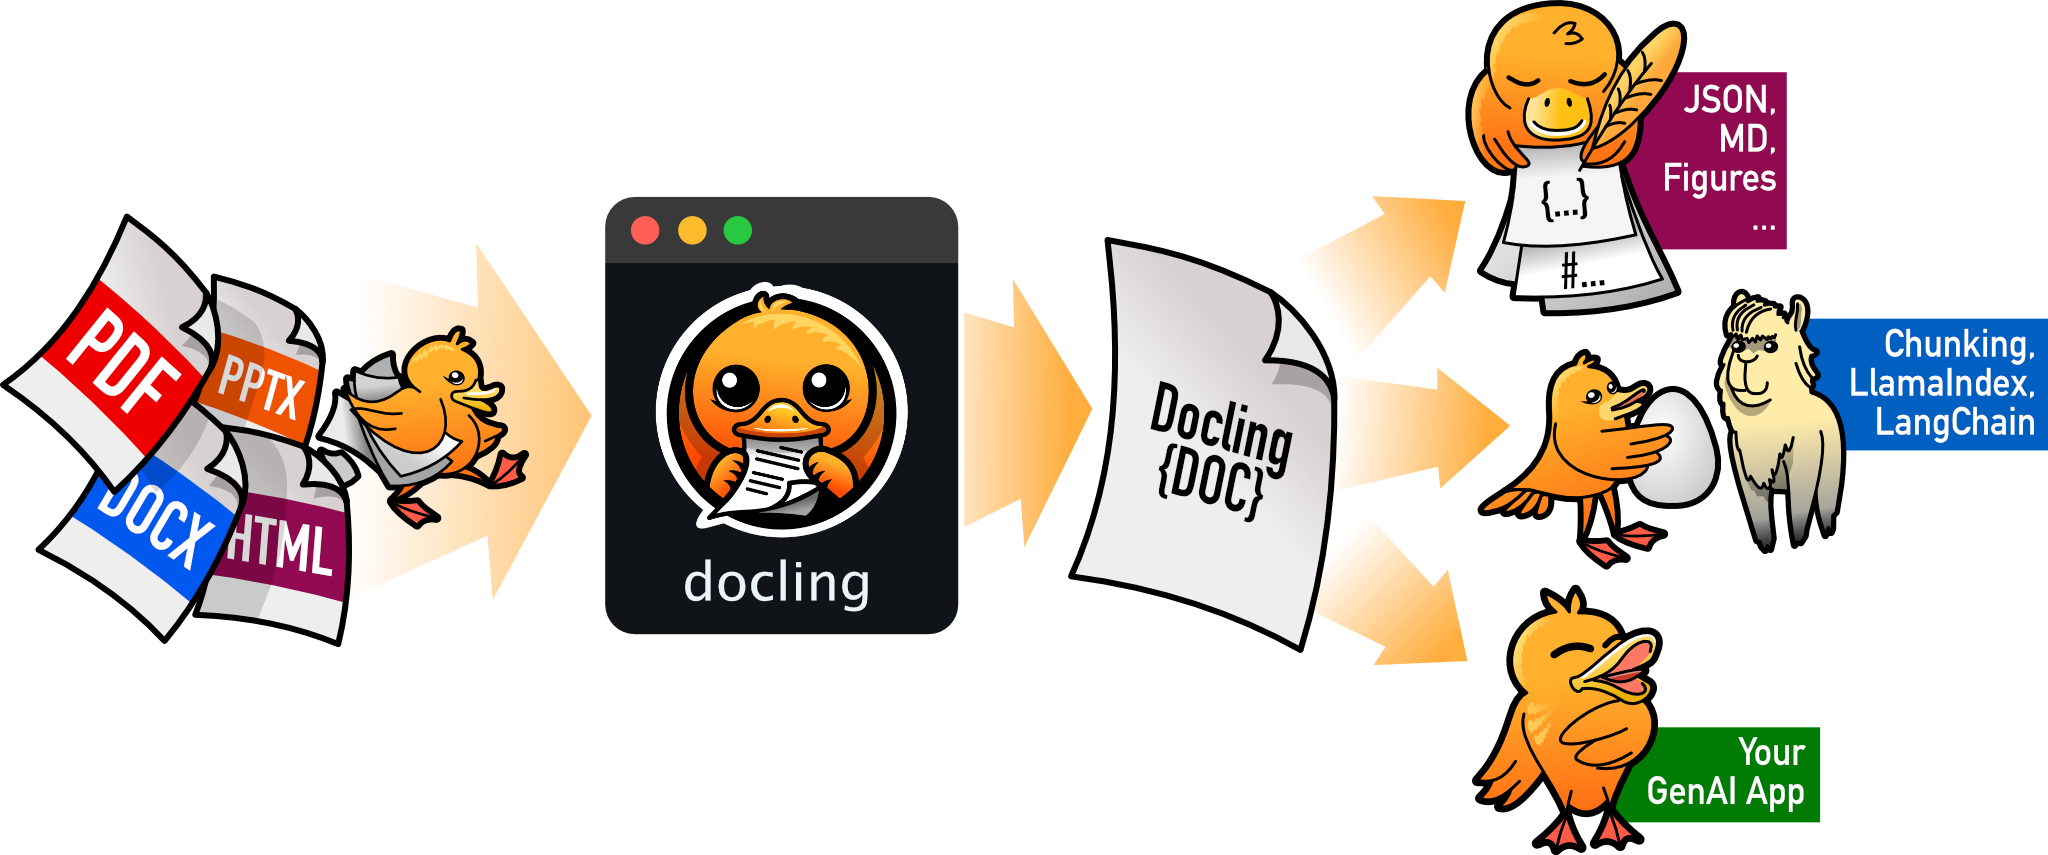

# Where in the RAG flow is this library useful? 

## RAG overview

At this point we are all quite familiar with what a RAG pipeline does. Very quickly, it usally consists of two parts: ingestion and retrieval/generation. Ingestion is the process in which we take documents and store them in a vector database whereas retrieval is the process of using this knowledge base in generating new answers. Docling comes into play primarily in ingestion, and specifically scraping documents for content/information. This means extracting all the information from files of the following types:

* .pdf
* .docx
* .pptx
* .html

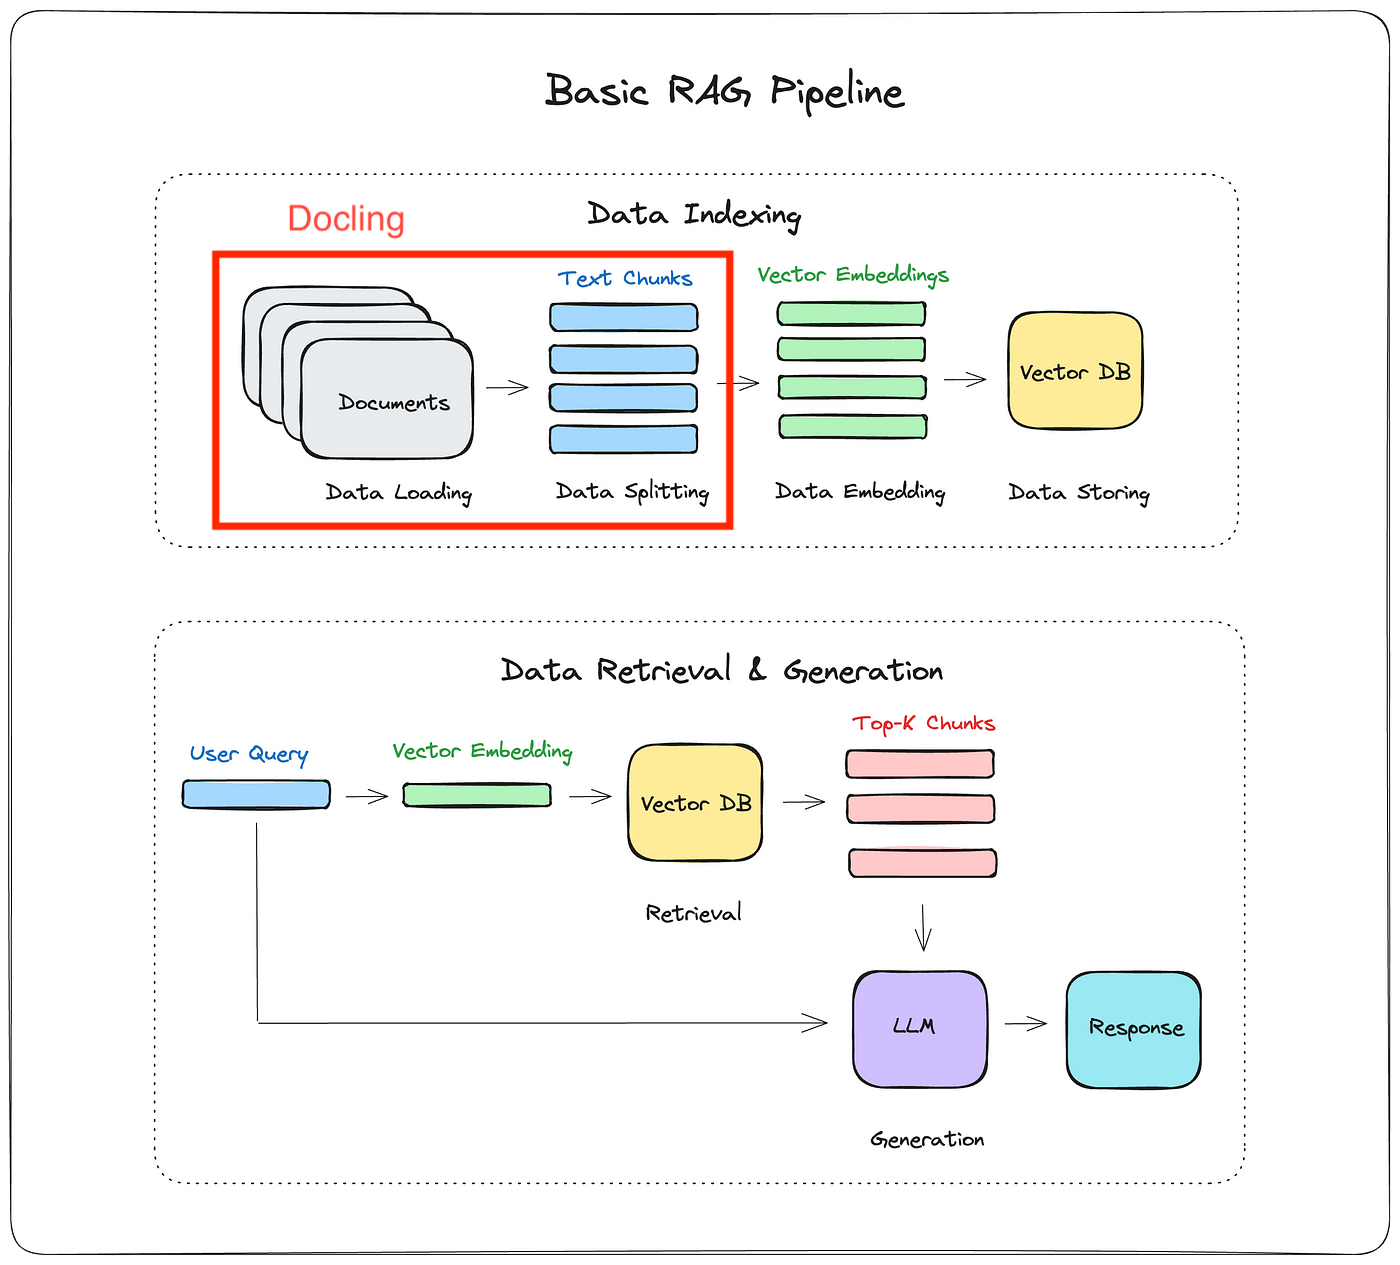

As far as I have gathered, the biggest hurdle with implemeting RAG systems is the scraping of information. Actually getting usable information from documents usually comes in the form of custom scrapers tailored for your own specific use case. Additionally, if the documents do not follow the format that you have made the scraper for, everything essentially falls apart. Creating scrapers is generally quite hard as well. Some file-times are more forgiving than others. For instance, creating scrapers for HTML, XML, Markdown and to some extent .docx files are generally reasonable. This is because there is alot of inherent metadata that you can use to programatically scrape. However, scraping vectorized documents, like pdfs is hell. This is where Docling comes in to the rescue. The team at IBM has essentially created a open-source scraper that is able to scrape documents and generate a new docling object which can be converted to md or JSON formats as needed. This document is thought to create a more "standardized" document format that can be used in things like RAG applications. 

# What concretely does docling do? 

This section is based on the Docling technical paper: https://arxiv.org/pdf/2408.09869

This is what the pdf parsing pipeline does:

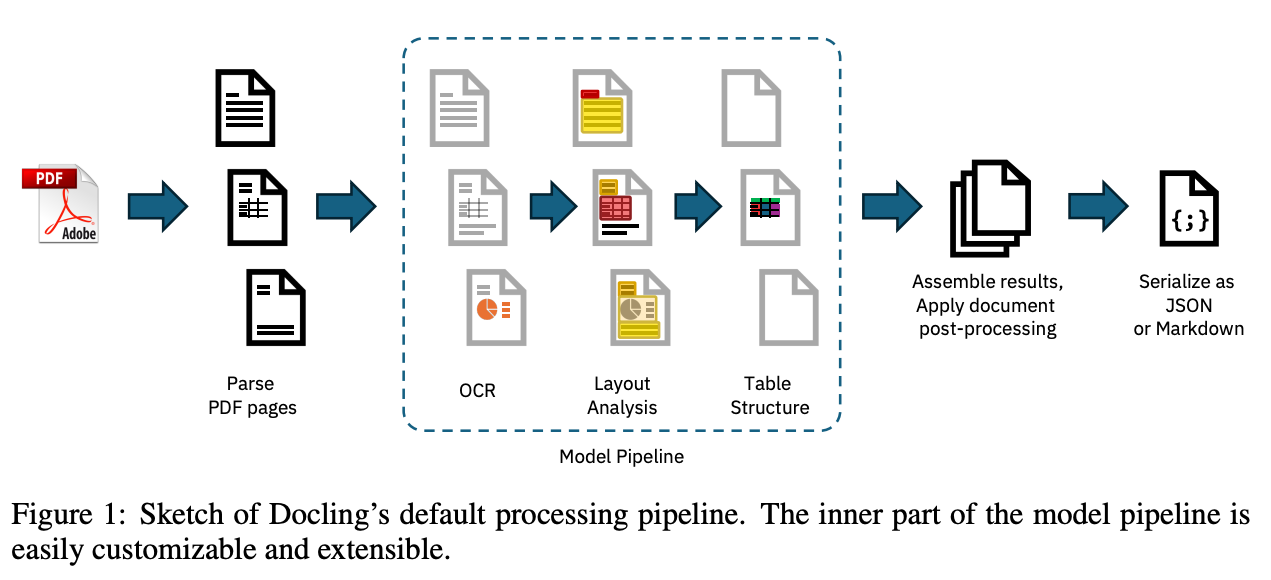

1. Each doc is parsed by a PDF backend, retrieving text tokens with the string content and its coordinate on the page. It also creates a bitmap image of each page. 
2. Stanard model applies a sequence of AI models independently on each page in the document to extract features and content, such as layout and table structures. 
3. Finally the result from all pages are aggregated and passed through a post-processing stage, which augments metadata, detects the document language, infers reading orer, and eventually assembles a typed document object what can be serialized to JSON or Markdown.  

## PDF backends
Two basic contitions: Retrieve all text and their geometric coordinates, render visual representation of each page as it would in a PDF viewer. 

Some problems Docling claims to solve using their custom built parser: restrictive lisencing, poor speed and unrecoverable quiality issues such as merged text cells across par-apart text tokens or table cloumns. 

Docling by default runs on their custom built open source PDF parser, based on low-level qpdf library, made available with the docling-parse package. However, you can also use other open soure pdf parsers such as pyPDF if you want to.

## AI models

Two models built by the IBM team, weights and everything are provided on Huggingface


### Layout Analysis Model

Purpose: 
* Classify components on a page into paragraphs, section titles, captions, figures and tables.

Model Architecture: 
* Based on RT-DETR
* Trained on DocLayNet: A Large Human-Annotated Dataset for Document-Layout Analysis and some proprietary documents.

Post Processing: 
* Overlap Removal: Overlapping bounding boxes are removed based on 
    * Confidence: Higher confidence predictions are favored
    * Size: Larger or more representative bounding boxes are prioritized.  
    * Intersect each of these with text tokens in the PDF to group them into meaningful nodes. 

https://huggingface.co/ds4sd/docling-models/discussions/5

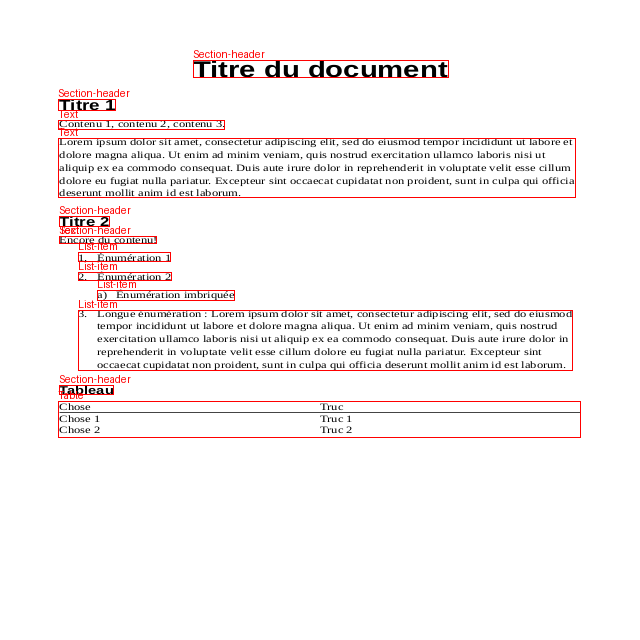

### Table Structure Recognition

Vision transformer model for table structure recovery. Predicts logial row and column structure of a given table based on input image. 
Determines which table cells beling to column and row headers and which belong to the table body. 

It is supposed to handle
* No borerlines
* Empty cells, rows and column
* Cell spans and hierarchi both on column heading or row-heading level
* Tables with inconsistent indentation or alignment 
* Other complexities

All identified tables from the layour analysis models are passed through this. It is passed as an image crop of the table and the included text cells associated with the table. 

Typical tables require 2-6 seconds to be processed. 

### OCR Support

OCR, Optical character recognition, is optional to be used with docling. It is useful for hand transcriptions. Slow, around 30 seconds per page. 

# Document Assembly

Final stage of the pipeline. Assembles all prediction results. The generated doc is passe through a post-processing model that leverages several algorithms to augment features, such as detetion of document language, correcting the reading order, matching figures with captions and labelling metadata such as title, authors and references. Output is then serialized to JSON. 

# Performance

Tested by processing 225 pages. 

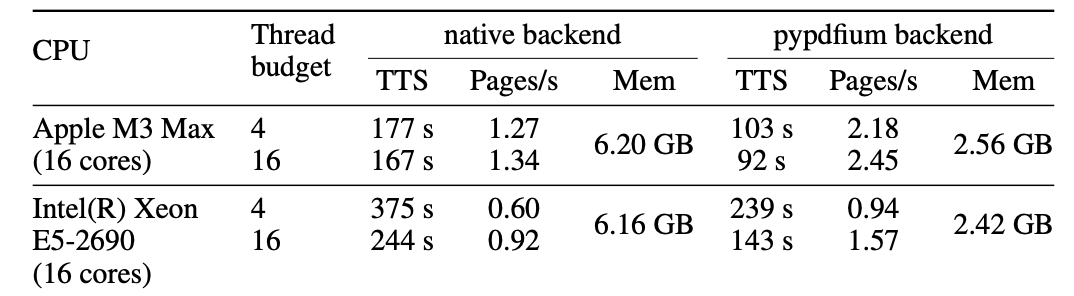

Note here that mem stands for Peak memory usage. Pypdfium uses less memory, however comes at the cost of quality of the parsing

# Work in progress: 

Figure classifier model, equation recognition model, code recognition model

# DocLayNet: A Large Human-Annotated dataset for Document-Layout Analysis

Team from IBM have created a large dataset of 80863 manually anotated pdf pages with layouts of different types of categories in rectangular labeled bounding-boxes. This is in contrast to existing datasets, like PubLayNet and DocBank, which are based on automated procedures, using Latex and XML metadata to label documents. The team uses 11 labels when they label the documents: 
* Caption, Footnote, Formula, List-item, Page-footer, Page-header, Picture, Section-header, Table, Text, and Title

The below image shows some of the documents that exist in the dataset, highlighting how the documents are labeled. 

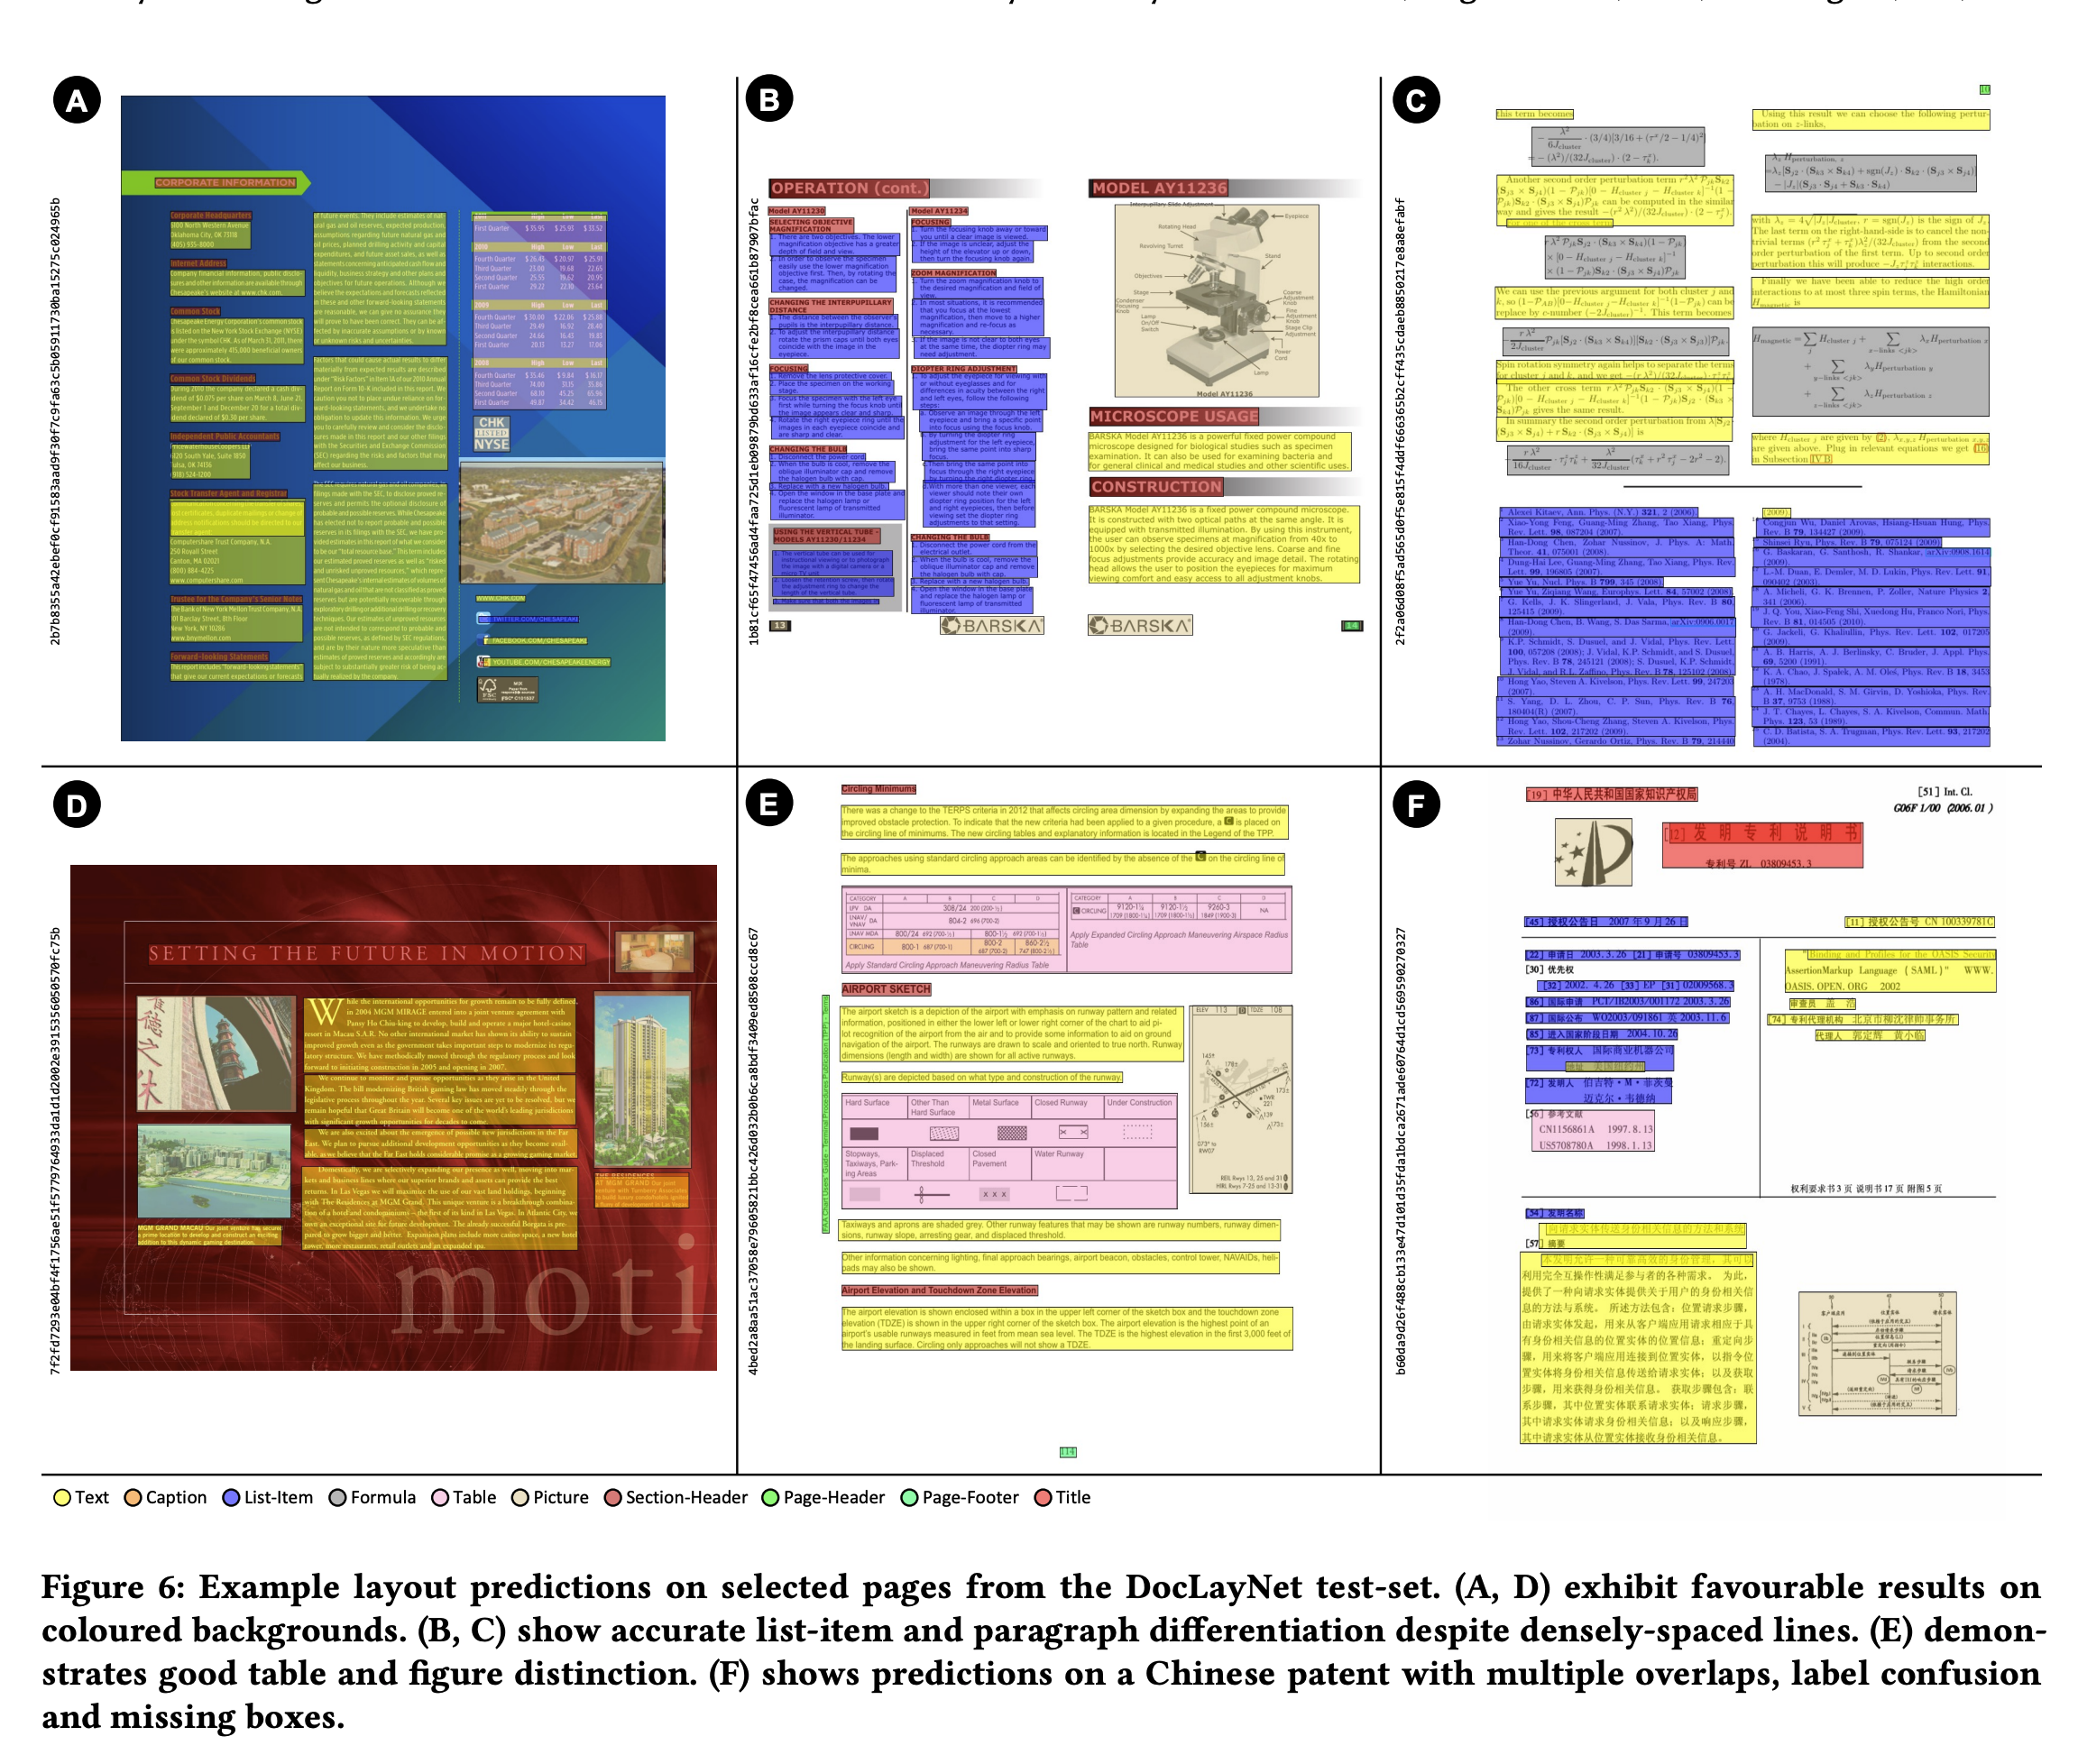


The authors of the paper find that 
* Models that are trained for object detection have performance that is impacted by the dataset size of DocLayNet, reducing the label set and modifying the train/test split. 
* They find that models trained DocLayNet over PubLayNet and DocBank provides overall more robust layout recovery, most likely due to the wide variety of documents found in the manually labeled dataset. 


Types of documents: 
* Little scanned documents
* medium to large docs with technical content, dense in complex
tables, figures, plots and captions. Such documents carry a lot of
information value, but are often hard to analyse with high accuracy
due to their challenging layouts

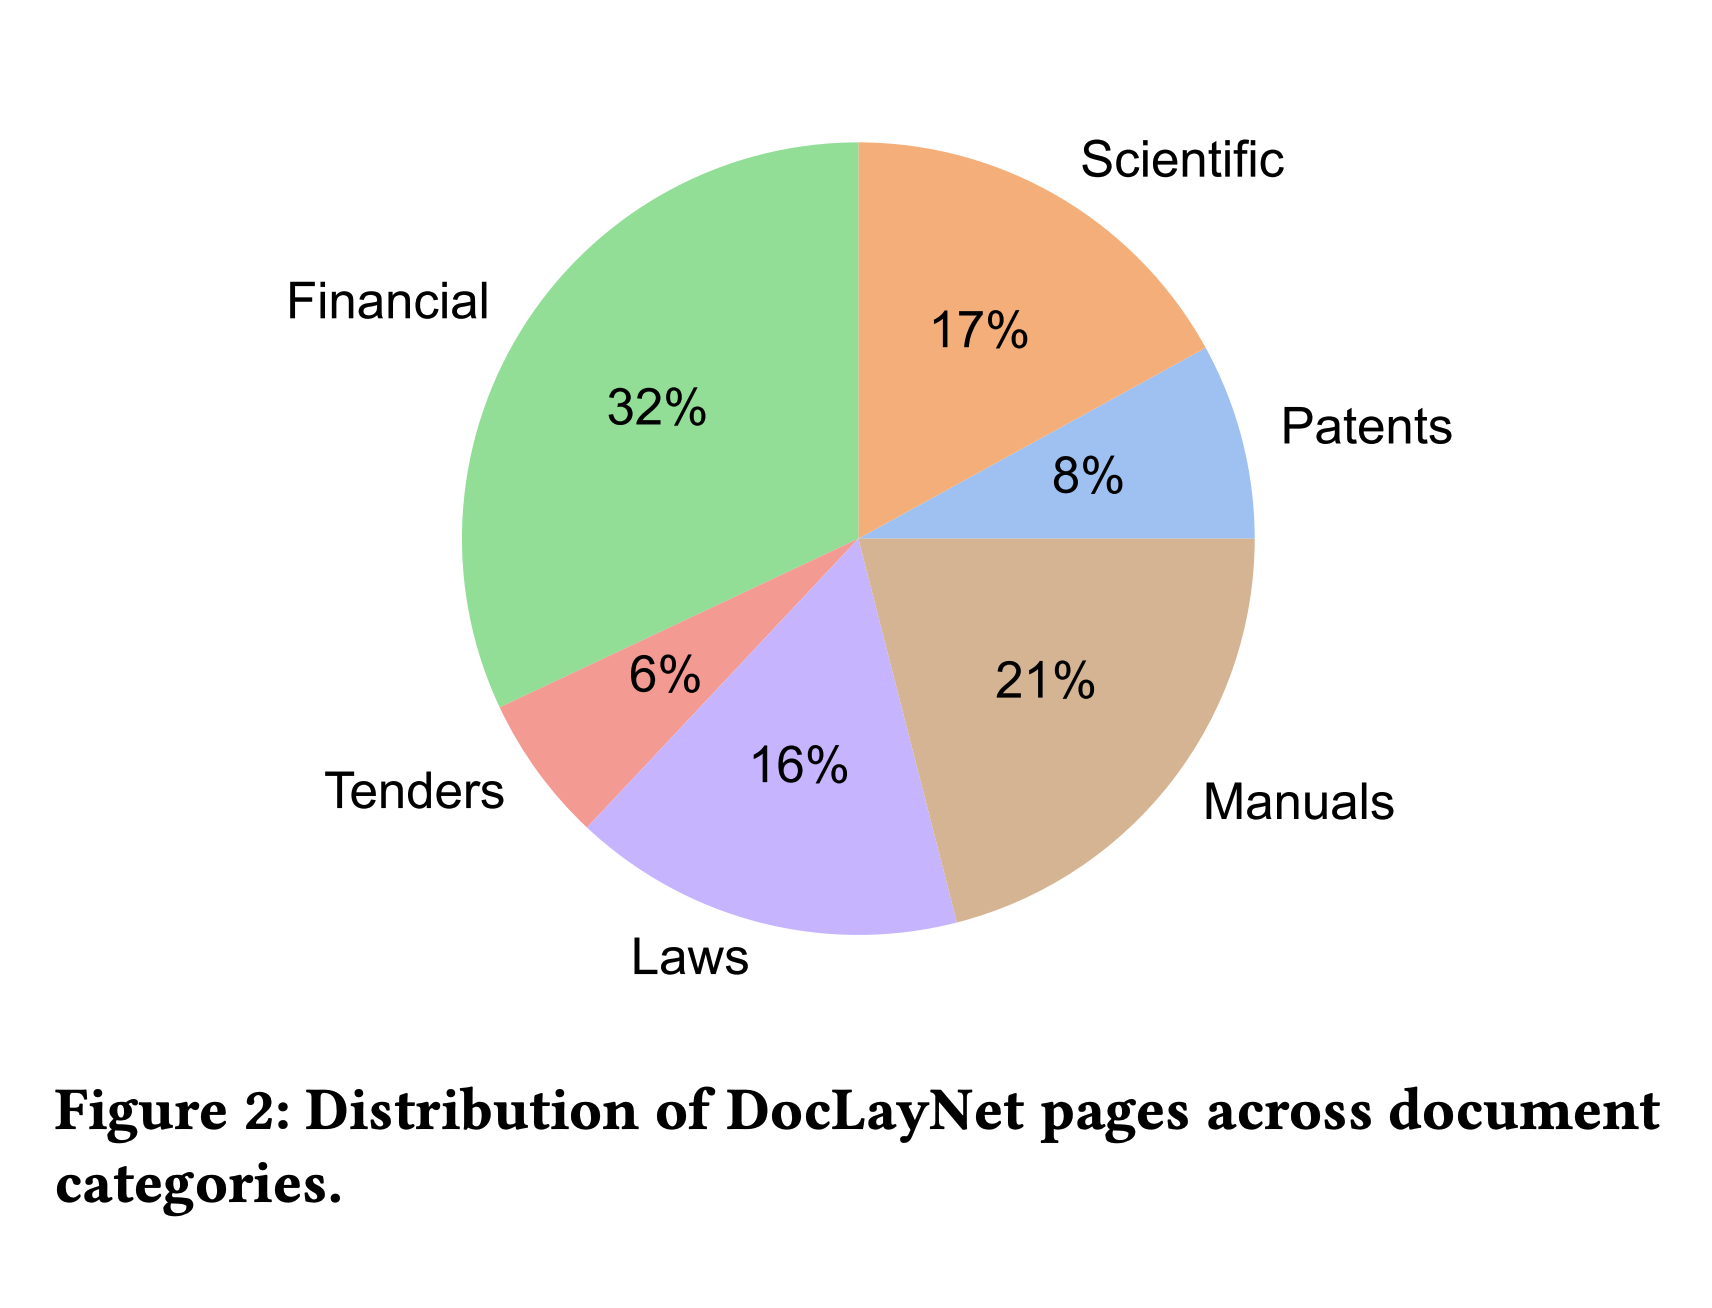


Perks of human-annoate dataset: 
* Freedom to annotate any type of document without requiring programmatic source
* More natural interpretation of page layout. "invisible table" for layout purposes is most likely interpreted as a stylistic choice for humans, but for an automated system it might predict the invisible bulletin's as indicating a table structure instead. 
* Generates a natural upper bound on the accuracy of the model since even humans disagree on how pages should be labeled. 

In [44]:
import os
from pathlib import Path
import pandas as pd
from docling.document_converter import DocumentConverter
from docling.chunking import HybridChunker, HierarchicalChunker
from docling.datamodel.document import DoclingDocument 
from llama_index.core.ingestion import IngestionPipeline
from llama_index.node_parser.docling import DoclingNodeParser
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.pipeline_options import PdfPipelineOptions, TableFormerMode
from docling.datamodel.base_models import InputFormat

In [2]:
from docling.document_converter import DocumentConverter

pipeline_options = PdfPipelineOptions(do_table_structure=True, generate_picture_images=True)
pipeline_options.table_structure_options.mode = TableFormerMode.ACCURATE  # use more accurate TableFormer model

converter = DocumentConverter(
        allowed_formats=[InputFormat.PDF, InputFormat.DOCX, InputFormat.IMAGE],
        format_options={
            InputFormat.PDF: PdfFormatOption(
                pipeline_options=pipeline_options,
            )
        }
    )

In [3]:
source = "/Users/viroshaanuthayamoorthy/Developer/RAG/DataProcessing/Data/Raw/md-to-pdf.pdf"  # document per local path or URL
result = converter.convert(source)

In [4]:
print(result.document.export_to_markdown())

## This is some title

Here I am writing some paragraph, bla bla bla

another line of writing for main title

## Subheading 1.0

Some more text, blah blah blah

Even more text

## Subheading 1.1

Some more text, blah blah blah * Morbi in sem quis dui placerat ornare. Pellentesque odio nisi, euismod in, pharetra a, ultricies in, diam. Sed arcu. Cras consequat

Praesent dapibus, neque id cursus faucibus, tortor neque egestas augue, eu vulputate magna eros eu erat. Aliquam erat volutpat. Nam dui mi, tincidunt quis, accumsan porttitor, facilisis luctus, metus.

- Phasellus ultrices nulla quis nibh. Quisque a lectus. Donec consectetuer ligula vulputate sem tristique cursus. Nam nulla quam, gravida non, commodo a, sodales sit amet, nisi. ·
- Pellentesque fermentum dolor. Aliquam quam lectus, facilisis auctor, ultrices ut, elementum vulputate, nunc. ·
- Sed adipiscing ornare risus. Morbi est est, blandit sit amet, sagittis vel, euismod vel, velit. Pellentesque egestas sem. Suspendisse commodo

In [5]:
result.document.save_as_json(Path("jeff.json"))

After inspecting the corresponding docling document for the result (inspect the saved JSON), there are some interesting points to note.

1. Docling parses each paragraph of the document at a time. 

2. The "Body" section of the document is essentially the entire document built up using all the parsed elements from docling. Each of these elements are hyperlinks which references other elements in the document. It consists of either simple elements or of groups of elements. 

3. Groups are quite interesting, and sort of shows how docling is able to understand the "global" structure of the document, and not just naively parse the document. Sure, it is not perfect, but works surprisingly well. Look for instance at the first group, group 0. In this group, we see that it is able to capture all the bulletpoints into a single group. Even more surprisingly it was able to capture that the bulletpoints continue onto the next page as well, and groups them together with the first group!
- On this note, I have found that this grouping might be a bit inconsistent, and that it might not work for all types of documents. As an example, consider the dataprotection.pdf conversion where there is plenty of unstructured data. Here we can see that the conversion struggles a bit with regards to grouping the elements "correctly"

In [6]:
chunker = HierarchicalChunker()
chunks = chunker.chunk(result.document)
list(chunks)

[DocChunk(text='Here I am writing some paragraph, bla bla bla', meta=DocMeta(schema_name='docling_core.transforms.chunker.DocMeta', version='1.0.0', doc_items=[TextItem(self_ref='#/texts/1', parent=RefItem(cref='#/body'), children=[], label=<DocItemLabel.TEXT: 'text'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=62.25, t=725.281982421875, r=345.7619934082031, b=711.325927734375, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 45))], orig='Here I am writing some paragraph, bla bla bla', text='Here I am writing some paragraph, bla bla bla')], headings=['This is some title'], captions=None, origin=DocumentOrigin(mimetype='application/pdf', binary_hash=11344757753028894437, filename='md-to-pdf.pdf', uri=None))),
 DocChunk(text='another line of writing for main title', meta=DocMeta(schema_name='docling_core.transforms.chunker.DocMeta', version='1.0.0', doc_items=[TextItem(self_ref='#/texts/2', parent=RefItem(cref='#/body'), children=[], label=<DocItemLabel.TEXT: 't

In [7]:
chunker2 = HybridChunker() # Note: you can provide custom tokenizers, as long as the model inherits from the transformers module in HuggingFace 
chunks2 = chunker2.chunk(result.document)
list(chunks2)

Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors


[DocChunk(text='Here I am writing some paragraph, bla bla bla\nanother line of writing for main title', meta=DocMeta(schema_name='docling_core.transforms.chunker.DocMeta', version='1.0.0', doc_items=[DocItem(self_ref='#/texts/1', parent=RefItem(cref='#/body'), children=[], label=<DocItemLabel.TEXT: 'text'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=62.25, t=725.281982421875, r=345.7619934082031, b=711.325927734375, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 45))]), DocItem(self_ref='#/texts/2', parent=RefItem(cref='#/body'), children=[], label=<DocItemLabel.TEXT: 'text'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=62.25, t=699.3129272460938, r=282.6659851074219, b=685.35693359375, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 38))])], headings=['This is some title'], captions=None, origin=DocumentOrigin(mimetype='application/pdf', binary_hash=11344757753028894437, filename='md-to-pdf.pdf', uri=None))),
 DocChunk(text='Some m

In [8]:
source = "/Users/viroshaanuthayamoorthy/Developer/RAG/DataProcessing/Data/Raw/2206.01062v1.pdf"  # document per local path or URL
result = converter.convert(source)
result.document.save_as_json(Path("doclingpaper.json"))

In [9]:
result.document.tables[0].export_to_dataframe()

class label    Count % of Total.Train % of Total.Test % of Total.Val  \
0          Caption    22524             2.04            1.77           2.32   
1         Footnote     6318             0.60            0.31           0.58   
2          Formula    25027             2.25            1.90           2.96   
3        List-item   185660            17.19           13.34          15.82   
4      Page-footer    70878             6.51            5.58           6.00   
5      Page-header    58022             5.10            6.70           5.06   
6          Picture    45976             4.21            2.78           5.31   
7   Section-header   142884            12.60           15.77          12.85   
8            Table    34733             3.20            2.27           3.60   
9             Text   510377            45.82           49.28          45.00   
10           Title     5071             0.47            0.30           0.50   
11           Total  1107470           941123           99816          66531   

   triple inter-annotator mAP @ 0.5-0.95 (%).All  \
0                                          84-89   
1                                          83-91   
2                                          83-85   
3                                          87-88   
4                                          93-94   
5                                          85-89   
6                                          69-71   
7                                          83-84   
8                                          77-81   
9                                          84-86   
10                                         60-72   
11                                         82-83   

   triple inter-annotator mAP @ 0.5-0.95 (%).Fin  \
0                                          40-61   
1                                            n/a   
2                                            n/a   
3                                          74-83   
4                                          88-90   
5                                          66-76   
6                                          56-59   
7                                          76-81   
8                                          75-80   
9                                          81-86   
10                                         24-63   
11                                         71-74   

   triple inter-annotator mAP @ 0.5-0.95 (%).Man  \
0                                          86-92   
1                                            100   
2                                            n/a   
3                                          90-92   
4                                          95-96   
5                                          90-94   
6                                          82-86   
7                                          90-92   
8                                          83-86   
9                                          88-93   
10                                         50-63   
11                                         79-81   

   triple inter-annotator mAP @ 0.5-0.95 (%).Sci  \
0                                          94-99   
1                                          62-88   
2                                          84-87   
3                                          97-97   
4                                            100   
5                                         98-100   
6                                          69-82   
7                                          94-95   
8                                          98-99   
9                                          89-93   
10                                        94-100   
11                                         89-94   

   triple inter-annotator mAP @ 0.5-0.95 (%).Law  \
0                                          95-99   
1                                          85-94   
2                                          86-96   
3                                          81-85   
4          

'\n\n'
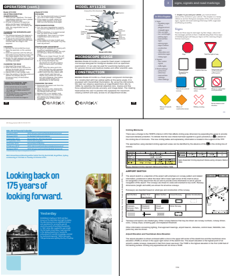

In [10]:
result.document.pictures[0].export_to_markdown(result.document)

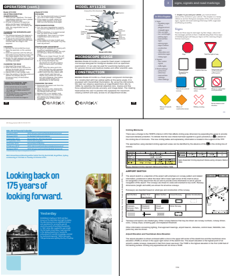

In [50]:
source = "/Users/viroshaanuthayamoorthy/Developer/RAG/DataProcessing/Data/Raw/dataprotection.pdf"  # document per local path or URL
result = converter.convert(source)
result.document.save_as_json(Path("dataprotection.json"))

In [43]:
from pathlib import Path
from datetime import datetime

pipeline_options = PdfPipelineOptions(do_table_structure=True)
pipeline_options.table_structure_options.mode = TableFormerMode.ACCURATE  # use more accurate TableFormer model

converter = DocumentConverter(
    allowed_formats=[InputFormat.PDF, InputFormat.DOCX, InputFormat.IMAGE],
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=pipeline_options,
        )
    }
)

folder_path = Path("/Users/viroshaanuthayamoorthy/Developer/RAG/DataProcessing/Data/Raw/Tables")
files = [Path(file) for file in folder_path.iterdir()]

output_folder = Path("/Users/viroshaanuthayamoorthy/Developer/RAG/DataProcessing/Data/Processed/Tables")
output_folder.mkdir(parents=True, exist_ok=True)  # Ensure output folder exists

convertedTables = converter.convert_all(files)
for file, table in zip(files, convertedTables):
    base_name = file.stem  # Get the base name of the file without extension
    for idx, smallTable in enumerate(table.document.tables):
        # Generate systematic name
        output_file_name = f"{base_name}_table_{idx + 1}.csv"
        output_file_path = output_folder / output_file_name
        
        # Export table to CSV
        smallTable.export_to_dataframe().to_csv(output_file_path, index=False)
        print(f"Exported: {output_file_path}")

Exported: /Users/viroshaanuthayamoorthy/Developer/RAG/DataProcessing/Data/Processed/Tables/other_table_big_table_1.csv
Exported: /Users/viroshaanuthayamoorthy/Developer/RAG/DataProcessing/Data/Processed/Tables/NVIDIA_Report_Removed_Pages-1-16-14_page-0001_table_1.csv
Exported: /Users/viroshaanuthayamoorthy/Developer/RAG/DataProcessing/Data/Processed/Tables/table_3_cropped_table_1.csv
Exported: /Users/viroshaanuthayamoorthy/Developer/RAG/DataProcessing/Data/Processed/Tables/NVIDIA_Report_Removed_Pages-1-16-9_page-0001_table_1.csv
Exported: /Users/viroshaanuthayamoorthy/Developer/RAG/DataProcessing/Data/Processed/Tables/NVIDIA_Report_Removed_Pages-1-16-9_page-0001_table_2.csv
Exported: /Users/viroshaanuthayamoorthy/Developer/RAG/DataProcessing/Data/Processed/Tables/NVIDIA_Report_Removed_Pages-1-16-9_page-0001_table_3.csv
Exported: /Users/viroshaanuthayamoorthy/Developer/RAG/DataProcessing/Data/Processed/Tables/other_table_big_cropped_table_1.csv
Exported: /Users/viroshaanuthayamoorthy/De

Very interesting point. From the technical paper on the deep learning model used for these document parsers: https://arxiv.org/pdf/2203.01017 it seems that the TableFormer leverages alot of data from the original PDF as well. So if the pdf is programmatic (i.e we are able to copy paste elements from the pdf), the model is expected to perform much better than of the table is "non-searchable". This is because the text-cells can be extracted much faster and with higher accuracy than having to rely on OCR methods. 

In [48]:
file_path = '/Users/viroshaanuthayamoorthy/Developer/RAG/DataProcessing/Data/Processed/Tables/NVIDIA_Report_Removed_Pages-1-16-14_page-0001_table_1.csv'  # Replace 'your_file.csv' with the actual path to your CSV file

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Display the DataFrame in the notebook
df

Unnamed: 0 Jan 28,2024 Jan 29,2023
0                                              Assets         NaN         NaN
1                                     Current assets:         NaN         NaN
2                           Cash and cash equivalents       7,280     $ 3,389
3                               Marketable securities      18,704       9,907
4                            Accounts receivable; net       9,999       3,827
5                                         Inventories       5,282       5,159
6           Prepaid expenses and other current assets       3,080         791
7                                Total current assets         NaN      23,073
8                         Property and equipment; net       3,914       3,807
9                              Operating lease assets       1,346       1,038
10                                           Goodwill       4,430       4,372
11                             Intangible assets, net       1,112       1,676
12                         Deferred income tax assets       6,081       3,396
13                                                NaN       4,500       3,820
14                                       Total assets    $ 65,728    $ 41,182
15               Liabilities and shareholders' Equity         NaN         NaN
16                               Current liabilities:         NaN         NaN
17                                   Accounts payable     $ 2,699     $ 1,193
18              Accrued and other current liabilities       6,682       4,120
19                                    Short-term debt       1,250       1,250
20                          Total current liabilities      10,631       6,563
21                                     Long-term debt       8,459       9,703
22              Long-term operating lease liabilities         NaN         902
23                        Other long-term liabilities       2,541       1,913
24                                  Total liabilities      22,750      19,081
25          Commitments and contingencies see Note 13         NaN         NaN
26                              Shareholders' equity:         NaN         NaN
27  Preferred stock; $0.001 par value; 2 shares au...         NaN         NaN
28  Common stock; $0.001 par value; 8,000 shares a...           2           2
29                         Additional paid-in capital      13,132      11,971
30      Accumulated other comprehensive income (loss)          27        (43)
31                                  Retained earnings      29,817      10,171
32                         Total shareholders' equity      42,978      22,101
33         Total liabilities and shareholders' equity    $ 65,728    $ 41,182

In [51]:
source = "/Users/viroshaanuthayamoorthy/Developer/RAG/DataProcessing/Data/Raw/acnq4.pdf"  # document per local path or URL
result = converter.convert(source)
result.document.tables[0].export_to_dataframe()

\
0                                           REVENUES:   
1                                            Revenues   
2                                 OPERATING EXPENSES:   
3                                    Cost of services   
4                                 Sales and marketing   
5                    General and administrative costs   
6                         Business optimization costs   
7                            Total operating expenses   
8                                    OPERATING INCOME   
9                                     Interest income   
10                                   Interest expense   
11                        Other (expense) income, net   
12                         INCOME BEFORE INCOME TAXES   
13                                 Income tax expense   
14                                         NET INCOME   
15  Net income attributable to  noncontrolling int...   
16  Net income attributable to  noncontrolling int...   
17          NET INCOME ATTRIBUTABLE TO  ACCENTURE PLC   
18                CALCULATION OF EARNINGS PER  SHARE:   
19           Net income attributable to Accenture plc   
20  Net income attributable to  noncontrolling int...   
21  Net income for diluted earnings per  share cal...   
22                           WEIGHTED AVERAGE SHARES:   
23                                              Basic   
24                                            Diluted   
25                                EARNINGS PER SHARE:   
26                                              Basic   
27                                            Diluted   
28                           Cash dividends per share   

   Three Months Ended.August 31, 2024 Three Months Ended.% of  Revenues  \
0                                                                         
1                       $  16,405,819                           100.0 %   
2                                                                         
3                          11,068,363                            67.5 %   
4                           1,755,272                            10.7 %   
5                           1,122,569                             6.8 %   
6                             105,947                             0.6 %   
7                          14,052,151                                     
8                           2,353,668                            14.3 %   
9                              51,317                                     
10                           (22,835)                                     
11                           (49,589)                                     
12                          2,332,561                            14.2 %   
13                            613,895                                     
14                          1,718,666                            10.5 %   
15                            (1,606)                                     
16                           (32,759)                                     
17                       $  1,684,301                            10.3 %   
18                                                                        
19                       $  1,684,301                                     
20                              1,606                                     
21                       $  1,685,907                                     
22                                                                        
23                        626,122,298                                     
24                        633,883,494                                     
25                                                                        
26                            $  2.69                                     
27                            $  2.66                                     
28                            $  1.29                                     

   Three Months Ended.August 31, 2023 Three Months Ended.% of  Revenues  \
0                 

In [53]:
source = "/Users/viroshaanuthayamoorthy/Developer/RAG/DataProcessing/Data/Raw/Tables/acnq4.png"  # document per local path or URL
result = converter.convert(source)
result.document.tables[0].export_to_dataframe()

3 of.August 31, 2024  \
0                                           REVENUES:                        
1                                            Revenves         5 16,405,819   
2                                 OPERATING EXPENSES:                        
3                                    Cost of services           11,068,363   
4                                 Sales and marketing            1,755,272   
5                    General and administrative costs            1,122,569   
6                         Business optimization costs              105,947   
7                            Total oporating expenses           14,052,151   
8                                    OPERATING INCOME            2,353,668   
9                                     Interest income               51,317   
10                                   Interest expense             (22,835)   
11                        Other (expense) income, net             (49,589)   
12                         INCOME BEFORE INCOME TAXES            2,332,561   
13                                 Income tax expense              613,895   
14                                         NET INCOME            1,718,666   
15  Net income attributable to noncontrolling inte...              (1,606)   
16               Net income attributable to other (1)             (32,759)   
17             noncontrolling interests ACCENTURE PLC          5 1,684,301   
18                 CALCULATION OF EARNINGS PER SHARE:                        
19           Net income attnibutable to Accenture plc          5 1,684,301   
20  Net income attributable to noncontrolling inte...                1,606   
21  Net income for diluted carnings share calculat...          5 1,685,907   
22                           WEIGHTED AVERAGE SHARES:                        
23                                              Basic          626,122,298   
24                                            Diluted          633,883,494   
25                                EARNINGS PER SHARE:                        
26                                              Basic                5 269   
27                                            Diluted                    5   
28                                                                  5 1.29   

     3 of. 3 of.August 31, 2023 3 of.Rovonuos  \
0                                               
1                  5 15,985,200                 
2                                               
3   67.5 %           10,803,571        67.6 %   
4   10.7 %            1,730,422        10.8 %   
5    6.8 %            1,066,404         6.7 %   
6    0.6 %              471,883                 
7                    14,072,280                 
8   14.3 %            1,912,920        12.0 %   
9                       103,627                 
10                     (17,403)                 
11                     (40,017)                 
12  14.2 %            1,959,127        12.3 %   
13                      550,915                 
14  10.5 %            1,408,212         8.8 %   
15                      (1,414)                 
16                     (33,835)                 
17  10.3 %          5 1,372,963         8.6 %   
18                                              
19                            5                 
20                                              
21                  5 1,374,377                 
22                                              
23                  629,922,331                 
24                  639,249,070                 
25                                              
26                            5                 
27                        5 215                 
28                       5 1.12                 

   Year Ended August 31, 3 of.August 31, 2024 Year Ended August 31, 3 of.  \
0                                                                           
1                                5 64,896,464                     1d0.0 %   
2          

# How should docling fit in a wider RAG strategy? 

In my eyes, it is unnecessary to keep ingesting the same documents multiple times. Once the document is converted, we can apply operations directly on it. This is where docling comes into play in my eyes. Say you have 100+ files that you wish to digitize for further processing. My strategy in this case would be:

1. Create a batch job that goes through each of the documents and converts them into the docling format
2. Save these docling documents as JSON. This way, if we want to use these document at a later date, we do not have to for a long time to convert all the documents. Instead, we simply read from disk when we wish to retrieve the "documents", since the docling format is just as valid.
* The nice part about storing them this way is that if we notice errors in some of the conversions (some letters being incorrect, etc), we can simply go into the JSON-version of the document and fix it rather than having to create entire scripts that programatically does so. 
3. Once the documents have been created in the docling format, using these is relatively simple. Just load the docling docs from disk, then apply whatever operations on them as needed. This way, we can experiment with chunking much easier since chunking of docling docs is very simple and not very time consuming. We can then also play around with metadata at this point. We are essentially able to debug various operations much easier when the document is readily available in this format.

# Notes about Dockerization

It is possible to create a docker container that contains docling and use this in a cloud environment as well. Docling themselves provide a "default" dockerfile that one may use as a startingpoint:

https://github.com/DS4SD/docling/blob/main/Dockerfile

It looks like the following:

```docker
FROM python:3.11-slim-bookworm

ENV GIT_SSH_COMMAND="ssh -o StrictHostKeyChecking=no"

RUN apt-get update \
    && apt-get install -y libgl1 libglib2.0-0 curl wget git procps \
    && apt-get clean

# This will install torch with *only* cpu support
# Remove the --extra-index-url part if you want to install all the gpu requirements
# For more details in the different torch distribution visit https://pytorch.org/.
RUN pip install --no-cache-dir docling --extra-index-url https://download.pytorch.org/whl/cpu

ENV HF_HOME=/tmp/
ENV TORCH_HOME=/tmp/

COPY docs/examples/minimal.py /root/minimal.py

RUN python -c 'from deepsearch_glm.utils.load_pretrained_models import load_pretrained_nlp_models; load_pretrained_nlp_models(verbose=True);'
RUN python -c 'from docling.pipeline.standard_pdf_pipeline import StandardPdfPipeline; StandardPdfPipeline.download_models_hf(force=True);'

# On container environments, always set a thread budget to avoid undesired thread congestion.
ENV OMP_NUM_THREADS=4

# On container shell:
# > cd /root/
# > python minimal.py
```

Some key points:
* Python slim version for a smaller python image
* --no-cache-dir on docling disables caching on the docling install, reducing image size
* --extra-index-url https://download.pytorch.org/whl/cpu will download a CPU only version of pytorch, the biggest library dependency for docling. This will skip all cuda and GPU related installation, significantly decreasing the size of the image. 
* The two RUN python -c commands essntially downloads and caches two NLP models needed by docling. This will reduce runtime delays since they are now available in the container. 